In [1]:
import opendatasets as od
dataset='https://www.kaggle.com/datasets/engmohamedsshubber/violencedetectiondataset'
od.download(dataset)

100%|██████████| 1.02G/1.02G [05:23<00:00, 3.40MB/s]


In [2]:
img_height,img_width=64,64
sequence_length=20

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2

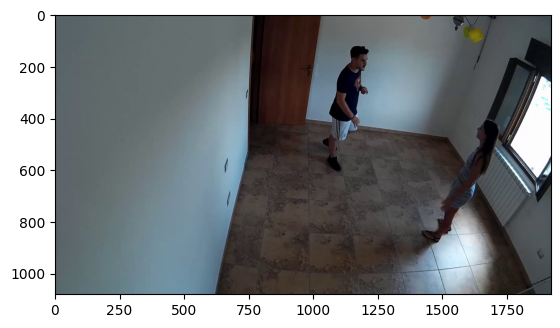

In [4]:
cap=cv2.VideoCapture('violencedetectiondataset/violence-detection-dataset/violent/1 (2).mp4')
_,frame=cap.read()
cap.release()
rgb_frame=cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
plt.imshow(rgb_frame)

In [7]:
dataset_folder=os.listdir('violencedetectiondataset/violence-detection-dataset')
print(len(dataset_folder))
print(dataset_folder)

2
['non-violent', 'violent']


In [5]:
def frames_extractor(video_path):
  frames_list=[]
  cap=cv2.VideoCapture(video_path)
  number_of_frames_in_video=int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
  skip_frames_window=max(int(number_of_frames_in_video/sequence_length),1)
  for frame_counter in range(sequence_length):
    cap.set(cv2.CAP_PROP_FRAME_COUNT,frame_counter*skip_frames_window)
    success,frame=cap.read()
    if not success:
      break
    resized_frame=cv2.resize(frame,(img_height,img_width))
    normalized_frame=resized_frame/255
    frames_list.append(normalized_frame)
  cap.release()
  return frames_list

In [22]:
data=[]

In [23]:
violent_folder_path='violencedetectiondataset/violence-detection-dataset/violent'
violence_folder=os.listdir(violent_folder_path)
violence_folder_length=len(violence_folder)
for i in range(violence_folder_length):
    video_path=violent_folder_path+'/'+violence_folder[i]
    frame=frames_extractor(video_path)
    if(len(frame)==sequence_length):
        data.append([frame,1])

In [24]:
non_violent_folder_path='violencedetectiondataset/violence-detection-dataset/non-violent'
non_violence_folder=os.listdir(non_violent_folder_path)
non_violence_folder_length=len(non_violence_folder)
for i in range(non_violence_folder_length):
    non_video_path=non_violent_folder_path+'/'+non_violence_folder[i]
    frame=frames_extractor(non_video_path)
    if(len(frame)==sequence_length):
        data.append([frame,0])

In [25]:
import random
random.shuffle(data)

In [26]:
x=[]
y=[]

In [27]:
for i,j in data:
    x.append(i)
    y.append(j)

In [33]:
x=np.asarray(x)
y=np.array(y)

In [34]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.1,random_state=0)

In [35]:
import os
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [36]:
def create_LRCN_model():
    # We will use a Sequential model for model construction.
    model = Sequential()
    
    # Define the Model Architecture.
    ########################################################################################################################
    
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (sequence_length, img_height, img_width, 3)))
    
    model.add(TimeDistributed(MaxPooling2D((4, 4)))) 
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(TimeDistributed(Dropout(0.25)))
                                      
    model.add(TimeDistributed(Flatten()))
                                      
    model.add(LSTM(32))
                                      
    model.add(Dense(2, activation = 'softmax'))
 
    ########################################################################################################################
 
    # Display the models summary.
    model.summary()
    
    # Return the constructed LRCN model.
    return model

In [37]:
LRCN_model = create_LRCN_model()
 
# Display the success message.
print("Model Created Successfully!")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_24 (TimeD  (None, 20, 64, 64, 16)    448       
 istributed)                                                     
                                                                 
 time_distributed_25 (TimeD  (None, 20, 16, 16, 16)    0         
 istributed)                                                     
                                                                 
 time_distributed_26 (TimeD  (None, 20, 16, 16, 16)    0         
 istributed)                                                     
                                                                 
 time_distributed_27 (TimeD  (None, 20, 16, 16, 32)    4640      
 istributed)                                                     
                                                                 
 time_distributed_28 (TimeD  (None, 20, 4, 4, 32)     

In [38]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
 
# Compile the model and specify loss function, optimizer and metrics to the model.
LRCN_model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])
 
# Start training the model.
LRCN_model_training_history = LRCN_model.fit(x=x_train,y=y_train, epochs = 70, batch_size = 4 , shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/70
63/63 [==============================] - 15s 90ms/step - loss: 0.6443 - accuracy: 0.6627 - val_loss: 0.6385 - val_accuracy: 0.6825
Epoch 2/70
63/63 [==============================] - 4s 70ms/step - loss: 0.6565 - accuracy: 0.6667 - val_loss: 0.6291 - val_accuracy: 0.6825
Epoch 3/70
63/63 [==============================] - 5s 75ms/step - loss: 0.6398 - accuracy: 0.6667 - val_loss: 0.6255 - val_accuracy: 0.6825
Epoch 4/70
63/63 [==============================] - 4s 60ms/step - loss: 0.6295 - accuracy: 0.6548 - val_loss: 0.6145 - val_accuracy: 0.6825
Epoch 5/70
63/63 [==============================] - 4s 62ms/step - loss: 0.5921 - accuracy: 0.6825 - val_loss: 0.5311 - val_accuracy: 0.7460
Epoch 6/70
63/63 [==============================] - 4s 68ms/step - loss: 0.4532 - accuracy: 0.7976 - val_loss: 0.4671 - val_accuracy: 0.8254
Epoch 7/70
63/63 [==============================] - 4s 71ms/step - loss: 0.3499 - accuracy: 0.8611 - val_loss: 0.4427 - val_accuracy: 0.8254
Epoch 8/70
6

In [46]:
video_path='violencedetectiondataset/violence-detection-dataset/non-violent/5 (2).mp4'
frame=frames_extractor(video_path)
predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frame, axis = 0))[0]
print(predicted_labels_probabilities)
output=np.argmax(predicted_labels_probabilities)
print(output)

1/1 [==============================] - 0s 54ms/step
[0.4875204  0.51247966]
1
